<img src='https://next.ific.uv.es/next/templates/rt_quasar_j15/images/logo/stylenext/logo.png' style='height: 40px' />


# SiPM S1 simulation
In this widget we simulate the sum of the signals coming from SiPMs coupled to wavelength shifting fibers. The fibers are assumed to uniformly cover the longitudinal side of the barrel.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil, exp, pi
import ipywidgets as widgets
np.random.seed(42)

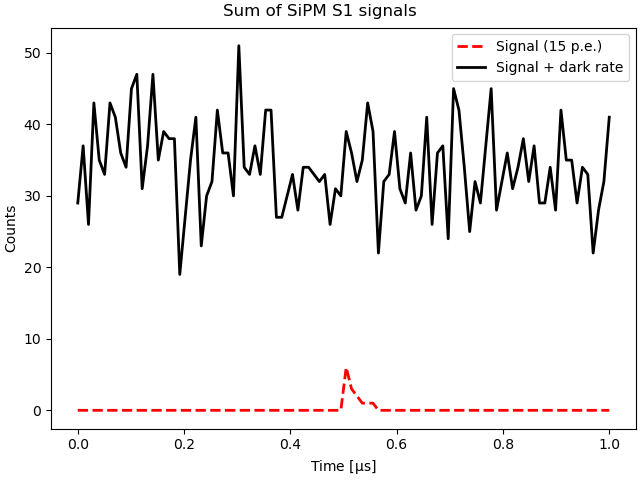

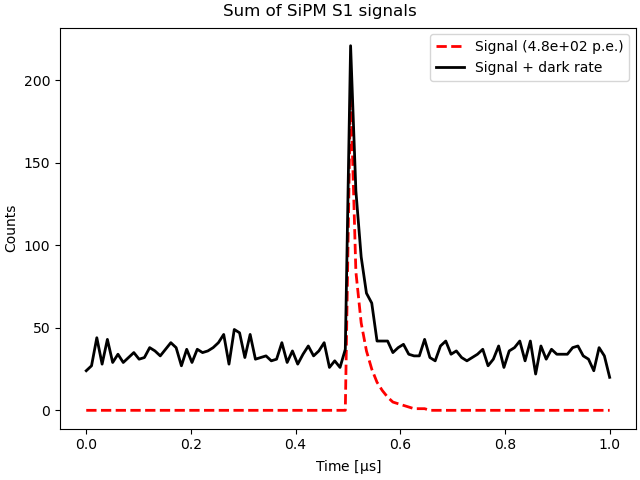

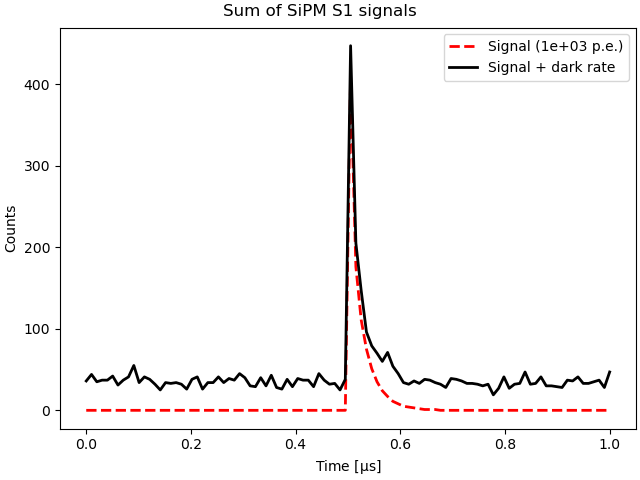

In [5]:
style = {'description_width': 'initial'}
detector_diameter = widgets.FloatSlider(description='Detector diameter [m]',
                                        style=style,
                                        min=2,
                                        max=3,
                                        value=2.5)
fiber_diameter = widgets.IntSlider(description='Fiber diameter [mm]',
                                   style=style,
                                   min=1,
                                   max=2)

sipm_type = widgets.SelectionSlider(
    options=['3x3', '6x6', '10x10'],
    description='SiPM area [mm$^2$]',
    style=style
)
n_photons = widgets.IntSlider(description='Number of photons',
                              style=style,
                              min=0,
                              value=1000,
                              max=5000)
efficiency = widgets.FloatSlider(description='Efficiency [%]',
                                 style=style,
                                 min=0,
                                 value=2,
                                 max=100)
dark_rate = widgets.FloatLogSlider(description='SiPM dark rate [MHz]',
                                   value=4,
                                   base=10,
                                   min=-3,
                                   max=2,
                                   step=0.2,
                                   style=style
)



Output()

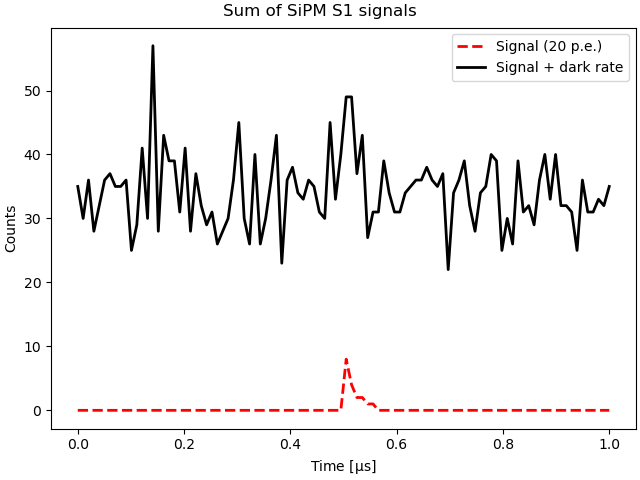

In [6]:
def light_signal(t, t0, f, ts, tt):
    if t-t0 > 0:
        return f * 1./ts * exp(-(t-t0)/ts) + (1-f) * 1./tt * exp(-(t-t0)/tt)
    else:
        return 0

def xenon_light(t, t0):
    f = 0.25
    ts = 0.0043
    tt = 0.0269
    return light_signal(t, t0, f, ts, tt)

v_xenon_light = np.vectorize(xenon_light, otypes=[np.float64])

def gui(sipm_type, n_photons, fiber_diameter, efficiency, detector_diameter, dark_rate):
    if sipm_type == '10x10':
        sipm_area = 100
    elif sipm_type == '6x6':
        sipm_area = 36
    else:
        sipm_area = 9
    
    n_pes = n_photons * efficiency / 100
    n_fibers = int(ceil(detector_diameter*pi/(fiber_diameter * 1e-3)))
    n_sipms = int(ceil(n_fibers/(sipm_area/(fiber_diameter**2))))

    sipms = np.zeros((n_sipms,100))
    counts = np.random.poisson(dark_rate, n_sipms)
    for ic,c in enumerate(counts):
        sipms[ic][np.random.randint(100, size=c)] = 1

    fig, ax = plt.subplots(1,1,constrained_layout=True)
    x = np.linspace(0,1,100)
    summed_signals = np.sum(sipms,axis=0)
    signal = np.round(n_pes*v_xenon_light(x, 0.5)/x.shape[0])
    summed_signals += signal
    ax.plot(x,signal, label=f'Signal ({n_pes:.2g} p.e.)', c='r', lw=2, ls='--')
    ax.plot(x,summed_signals,label=f"Signal + dark rate", lw=2, c='k')

    ax.set_xlabel(r"Time [$\mathrm{\mu}$s]")
    ax.set_ylabel("Counts")
    ax.legend(loc='upper right')
    fig.suptitle('Sum of SiPM S1 signals')

out = widgets.interactive_output(gui, {'sipm_type': sipm_type,
                                       'n_photons': n_photons, 
                                       'fiber_diameter': fiber_diameter,
                                       'efficiency': efficiency, 
                                       'detector_diameter': detector_diameter,
                                       'dark_rate': dark_rate})
ui = widgets.VBox([sipm_type, dark_rate, n_photons, fiber_diameter, efficiency, detector_diameter])
display(ui, out)



<hr>
Stefano Roberto Soleti - <a href="mailto:roberto.soleti@dipc.org">roberto.soleti@dipc.org</a>